# Project E – CoordConv CNN for Object Classification and Bounding Box Regression

This notebook trains and evaluates a convolutional neural network that can **classify** which object appears in a frame and **localize** it with a **bounding box**. The model uses a U-Net–style encoder–decoder with residual blocks and a CoordConv-style bounding box head.

## Abstract

In this project, we work with a custom dataset of short videos containing five object classes:
**Ball, Mug, Pen, Spoon,** and **Notebook**. Each frame in a video has:

- A **class label** indicating which object is present, and  
- A **bounding box** `[x, y, width, height]` that localizes the object in the image.

Our goals are:

1. **Object classification** – predict which of the five object classes appears in each frame.  
2. **Object localization** – predict a tight bounding box around that object.

To achieve this, we:

- Flatten all video frames into a single frame-level dataset.
- Filter out invalid bounding boxes and normalize coordinates.
- Use a **tf.data pipeline** with data augmentation (brightness, contrast, horizontal flip).
- Build a **U-Net–like CNN** with **residual blocks**.
- Add a **CoordConv layer** for the bounding-box head to inject explicit spatial coordinates.
- Train a **multi-task model** with two heads:
  - a softmax classification head, and  
  - a regression head for normalized bounding boxes.

Finally, we evaluate the model using **classification accuracy** and **Intersection over Union (IoU)**, and visualize predictions against ground truth.

## 1. Imports, Kaggle paths, and data loading

This block:

- Imports all necessary libraries (NumPy, TensorFlow/Keras, sklearn, etc.).
- Points to the `.npy` files stored in the Kaggle dataset (`/kaggle/input/fundation`).
- Loads the raw video data and labels.
- Flattens videos into individual frames so each frame becomes one training sample.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input, callbacks, initializers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Paths to the .npy data mounted from your Kaggle dataset "fundation"
DATA_PATH = '/kaggle/input/fundation/training_data_projectE.npy'
LABEL_PATH = '/kaggle/input/fundation/training_labels_projectE.npy'

# Load raw videos and labels
videos_raw = np.load(DATA_PATH)
labels_raw = np.load(LABEL_PATH, allow_pickle=True)

# videos_raw shape: (N videos, F frames, H, W, C)
N, F, H, W, C = videos_raw.shape

# Flatten videos to frame-level samples and scale pixels to [0, 1]
X_flat = videos_raw.reshape(N * F, H, W, C).astype('float32') / 255.0

# Flatten label array; each entry is [class_id, x, y, w, h]
y_flat = labels_raw.reshape(N * F, 5).astype('float32')

2025-12-01 20:26:19.269882: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764620779.458815      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764620779.514615      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

## 2. Extract labels, filter invalid bounding boxes, and normalize

Here we:

- Split the label vector into:
  - `classes_all` → integer class IDs (1–5).
  - `bboxes_all` → bounding-box coordinates `[x, y, w, h]` in pixels.
- Convert class labels to **0-based indices** (0–4) for `sparse_categorical_crossentropy`.
- Create a `valid_mask` to filter out frames with zero-size boxes (width or height ≤ 0).
- Normalize bounding boxes by dividing by 100 so all coordinates are in \[0, 1\], which works naturally with a `sigmoid` output layer.

In [2]:
# Class IDs (1..5) and bounding boxes [x, y, w, h] in pixels
classes_all = y_flat[:, 0] - 1  # convert to 0..4
bboxes_all = y_flat[:, 1:]

# Keep only samples with non-zero width and height
valid_mask = (bboxes_all[:, 2] > 0) & (bboxes_all[:, 3] > 0)

X_valid = X_flat[valid_mask]
classes_valid = classes_all[valid_mask]
bboxes_valid = bboxes_all[valid_mask]

# Normalize bounding boxes to [0, 1] since images are 100x100
bboxes_valid = bboxes_valid / 100.0

print(f"Valid Sample Number: {len(X_valid)} (Original: {len(X_flat)})")

Valid Sample Number: 7319 (Original: 7320)


## 3. Train / validation split

We split the filtered data into:

- 80% training
- 20% validation

We use **stratified splitting** on the class labels so each class is well represented in both training and validation sets.

In [3]:
X_train, X_val, y_cls_train, y_cls_val, y_box_train, y_box_val = train_test_split(
    X_valid,            # input images
    classes_valid,      # class labels
    bboxes_valid,       # bounding boxes
    test_size=0.2,
    random_state=42,
    stratify=classes_valid
)

## 4. Data augmentation and tf.data input pipelines

This block defines:

- An `augment` function that randomly:
  - Adjusts brightness and contrast.
  - Flips images horizontally with 50% probability.
  - Updates bounding boxes correctly when flipping.
- Two `tf.data.Dataset` pipelines:
  - `ds_train` – shuffles, augments, batches, and prefetches training data.
  - `ds_val` – batches validation data without augmentation.

This makes training more robust and efficient.

In [4]:
def augment(image, cls, bbox):
    # Random photometric augmentations
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    
    # Random horizontal flip
    do_flip = tf.random.uniform([]) > 0.5
    image = tf.cond(do_flip, lambda: tf.image.flip_left_right(image), lambda: image)
    
    # If we flip the image, we must also flip the bounding box
    def flip_box(b):
        x, y, w, h = b[0], b[1], b[2], b[3]
        new_x = 1.0 - (x + w)  # mirror around the vertical axis in normalized coords
        return tf.stack([new_x, y, w, h])
        
    bbox = tf.cond(do_flip, lambda: flip_box(bbox), lambda: bbox)
    
    # Ensure bbox stays in [0, 1]
    bbox = tf.clip_by_value(bbox, 0.0, 1.0)
    
    return image, {'class_out': cls, 'box_out': bbox}

BATCH_SIZE = 32
AUTO = tf.data.AUTOTUNE

# Training dataset: shuffle, augment, batch, prefetch
ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_cls_train, y_box_train))
ds_train = (
    ds_train
    .shuffle(2000)
    .map(augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Validation dataset: only batch, no augmentation
ds_val = tf.data.Dataset.from_tensor_slices((X_val, y_cls_val, y_box_val))
ds_val = ds_val.map(lambda x, c, b: (x, {'class_out': c, 'box_out': b})).batch(BATCH_SIZE)

I0000 00:00:1764620797.332687      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


## 5. CoordConv layer (AddCoords)

Standard convolutions do not know the absolute pixel coordinates in the image.  
The **AddCoords** layer appends two extra channels:

- `xx_channel` – normalized x-coordinates (column index)
- `yy_channel` – normalized y-coordinates (row index)

to the input feature map. This makes it easier for the network to reason about positions and sizes of bounding boxes.

In [5]:
class AddCoords(layers.Layer):
    def call(self, input_tensor):
        batch_size_tensor = tf.shape(input_tensor)[0]
        x_dim = tf.shape(input_tensor)[2]
        y_dim = tf.shape(input_tensor)[1]
        
        # xx_channel encodes column indices
        xx_ones = tf.ones([batch_size_tensor, x_dim], dtype='int32')
        xx_ones = tf.expand_dims(xx_ones, -1)
        xx_range = tf.tile(tf.expand_dims(tf.range(y_dim), 0), [batch_size_tensor, 1])
        xx_range = tf.expand_dims(xx_range, 1)
        xx_channel = tf.matmul(xx_ones, xx_range)
        xx_channel = tf.expand_dims(xx_channel, -1)
        xx_channel = tf.cast(xx_channel, 'float32') / (tf.cast(x_dim, 'float32') - 1)

        # yy_channel encodes row indices
        yy_ones = tf.ones([batch_size_tensor, y_dim], dtype='int32')
        yy_ones = tf.expand_dims(yy_ones, 1)
        yy_range = tf.tile(tf.expand_dims(tf.range(x_dim), 0), [batch_size_tensor, 1])
        yy_range = tf.expand_dims(yy_range, -1)
        yy_channel = tf.matmul(yy_range, yy_ones)
        yy_channel = tf.expand_dims(yy_channel, -1)
        yy_channel = tf.cast(yy_channel, 'float32') / (tf.cast(y_dim, 'float32') - 1)

        # Concatenate original features with coordinate channels
        return tf.concat([input_tensor, xx_channel, yy_channel], axis=-1)

## 6. Residual block and U-Net–style architecture

We define:

- A **residual block (`res_block`)**:
  - Two Conv–BN–LeakyReLU layers with a skip connection.
- A **U-Net–like encoder–decoder**:
  - Downsampling path: extract deep semantic features (`c1`, `c2`, `c3`, `b`).
  - Upsampling path: fuse deep features with earlier ones via skip connections.
- Two output heads:
  - **Classification head**: global average pooling on the deep feature `b`, followed by a dense softmax layer for 5 classes.
  - **Bounding box head**: uses the shallow decoder feature `c6` with CoordConv, followed by several conv layers and a dense layer that outputs 4 normalized box coordinates with a `sigmoid` activation.

In [6]:
def res_block(x, filters, stride=1):
    shortcut = x
    # Adjust shortcut if we change number of filters or spatial size
    if stride != 1 or x.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(x)
        shortcut = layers.BatchNormalization()(shortcut)
    
    # First conv
    x = layers.Conv2D(filters, 3, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    
    # Second conv
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    # Residual connection
    x = layers.Add()([x, shortcut])
    x = layers.LeakyReLU(alpha=0.1)(x)
    return x

def build_strong_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # Initial conv
    x = layers.Conv2D(32, 3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    
    # Encoder
    c1 = res_block(x, 32)
    p1 = layers.MaxPooling2D((2, 2))(c1) 
    
    c2 = res_block(p1, 64)
    p2 = layers.MaxPooling2D((2, 2))(c2) 
    
    c3 = res_block(p2, 128)
    p3 = layers.MaxPooling2D((2, 2))(c3) 
    
    b = res_block(p3, 256)  # bottleneck
    
    # Decoder with skip connections (U-Net style)
    u1 = layers.UpSampling2D((2, 2))(b) 
    u1 = layers.Conv2D(128, 3, padding='same')(u1)
    u1 = layers.Resizing(25, 25)(u1)
    u1 = layers.Concatenate()([u1, c3])
    c4 = res_block(u1, 128)
    
    u2 = layers.UpSampling2D((2, 2))(c4)
    u2 = layers.Resizing(50, 50)(u2)
    u2 = layers.Concatenate()([u2, c2])
    c5 = res_block(u2, 64)
    
    u3 = layers.UpSampling2D((2, 2))(c5)
    u3 = layers.Concatenate()([u3, c1])
    c6 = res_block(u3, 32) 
    
    # ---- Classification head (uses deep features) ----
    cls_pool = layers.GlobalAveragePooling2D()(b) 
    cls_drop = layers.Dropout(0.5)(cls_pool)
    class_out = layers.Dense(num_classes, activation='softmax', name='class_out')(cls_drop)

    # ---- Bounding box head (uses shallow features with CoordConv) ----
    box_in = AddCoords()(c6) 
    
    r = layers.Conv2D(64, 3, strides=2, padding='same')(box_in)
    r = layers.LeakyReLU(alpha=0.1)(r)
    
    r = layers.Conv2D(64, 3, strides=2, padding='same')(r)
    r = layers.LeakyReLU(alpha=0.1)(r)
    
    r = layers.Conv2D(128, 3, strides=2, padding='same')(r)
    r = layers.LeakyReLU(alpha=0.1)(r)
    
    r = layers.Flatten()(r)
    r = layers.Dropout(0.3)(r)
    r = layers.Dense(128)(r)
    r = layers.LeakyReLU(alpha=0.1)(r)
    
    box_out = layers.Dense(
        4,
        activation='sigmoid',
        name='box_out',
        bias_initializer=initializers.Constant(value=0.0)
    )(r)
    
    return models.Model(inputs, [class_out, box_out])

# Build model for 100x100 RGB images and 5 classes
model = build_strong_model((100, 100, 3), num_classes=5)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


## 7. Compile, train, and save the model

We now:

- Define a **cosine decay learning rate schedule** for the Adam optimizer.
- Use a **multi-task loss**:
  - `sparse_categorical_crossentropy` for class prediction.
  - `mae` (L1 loss) for bounding box regression.
- Weight the box loss higher (`loss_weights = {'class_out': 1.0, 'box_out': 10.0}`) to encourage accurate localization.
- Add callbacks:
  - `EarlyStopping` on validation loss (with patience 100, restoring best weights).
  - `ModelCheckpoint` to save the best model during training.
- Train for up to 100 epochs and save the final trained model.

In [7]:
# Cosine decay learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-4, 
    decay_steps=3000
)

# Compile model with multi-task losses
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss={
        'class_out': 'sparse_categorical_crossentropy',
        'box_out': 'mae'   # mean absolute error for bounding boxes
    },
    loss_weights={'class_out': 1.0, 'box_out': 10.0}, 
    metrics={'class_out': 'accuracy', 'box_out': 'mse'}
)

print("Starting Training with CoordConv...")

callbacks_list = [
    callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True),
    callbacks.ModelCheckpoint('../models/best_model_coord.keras', save_best_only=True)
]

history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=100,
    callbacks=callbacks_list,
    verbose=1
)

# Save final model in the working directory
model.save('/kaggle/working/final_model_coord.keras')

Starting Training with CoordConv...
Epoch 1/100


I0000 00:00:1764620815.272597     106 service.cc:148] XLA service 0x7a858c0035d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764620815.273423     106 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1764620817.153962     106 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/183 ━━━━━━━━━━━━━━━━━━━━ 15s 85ms/step - box_out_loss: 0.2021 - box_out_mse: 0.0584 - class_out_accuracy: 0.2188 - class_out_loss: 2.0161 - loss: 4.0368   

I0000 00:00:1764620832.799890     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


183/183 ━━━━━━━━━━━━━━━━━━━━ 69s 204ms/step - box_out_loss: 0.1379 - box_out_mse: 0.0328 - class_out_accuracy: 0.4061 - class_out_loss: 1.4533 - loss: 2.8320 - val_box_out_loss: 0.1951 - val_box_out_mse: 0.0568 - val_class_out_accuracy: 0.2070 - val_class_out_loss: 2.2802 - val_loss: 4.2296
Epoch 2/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - box_out_loss: 0.0903 - box_out_mse: 0.0161 - class_out_accuracy: 0.6010 - class_out_loss: 0.9740 - loss: 1.8767 - val_box_out_loss: 0.1338 - val_box_out_mse: 0.0316 - val_class_out_accuracy: 0.3866 - val_class_out_loss: 1.6915 - val_loss: 3.0291
Epoch 3/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - box_out_loss: 0.0772 - box_out_mse: 0.0123 - class_out_accuracy: 0.6855 - class_out_loss: 0.7898 - loss: 1.5616 - val_box_out_loss: 0.0791 - val_box_out_mse: 0.0129 - val_class_out_accuracy: 0.6380 - val_class_out_loss: 0.8817 - val_loss: 1.6718
Epoch 4/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - box_out_loss: 0.0678 - box_out_mse: 0.0097 - 

## 8. Load trained model and define IoU metric

This section:

- Reloads the trained model from disk (including the custom `AddCoords` layer).
- Defines `compute_iou`, a function that computes the **Intersection over Union (IoU)** between predicted and ground-truth bounding boxes, given as `[x, y, w, h]` in normalized coordinates.

In [8]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import matplotlib.patches as patches

# Load the trained model (requires AddCoords to be defined in this notebook)
model = tf.keras.models.load_model(
    '/kaggle/working/final_model_coord.keras',
    custom_objects={'AddCoords': AddCoords}
)

def compute_iou(box_true, box_pred):
    x1_t, y1_t, w_t, h_t = box_true[:, 0], box_true[:, 1], box_true[:, 2], box_true[:, 3]
    x2_t, y2_t = x1_t + w_t, y1_t + h_t
    
    x1_p, y1_p, w_p, h_p = box_pred[:, 0], box_pred[:, 1], box_pred[:, 2], box_pred[:, 3]
    x2_p, y2_p = x1_p + w_p, y1_p + h_p
    
    # Intersection rectangle
    x1_i = np.maximum(x1_t, x1_p)
    y1_i = np.maximum(y1_t, y1_p)
    x2_i = np.minimum(x2_t, x2_p)
    y2_i = np.minimum(y2_t, y2_p)
    
    w_i = np.maximum(0, x2_i - x1_i)
    h_i = np.maximum(0, y2_i - y1_i)
    inter_area = w_i * h_i
    
    # Union area
    box_t_area = w_t * h_t
    box_p_area = w_p * h_p
    union_area = box_t_area + box_p_area - inter_area
    
    return inter_area / (union_area + 1e-7)


## 9. Run model on all frames and compute predictions

We:

- Reload the raw data and reshape it into frames.
- Normalize the images and labels exactly as during training.
- Use `model.predict` to get:
  - `pred_probs` → softmax class probabilities.
  - `pred_boxes` → predicted normalized bounding boxes.
- Apply a **confidence threshold**:
  - If the max class probability < 0.7, we assign class **5 = UNKNOWN**.


In [9]:
DATA_PATH = '/kaggle/input/fundation/training_data_projectE.npy'
LABEL_PATH = '/kaggle/input/fundation/training_labels_projectE.npy'

X_raw = np.load(DATA_PATH)
y_raw = np.load(LABEL_PATH, allow_pickle=True)

# Flatten videos into frames and normalize pixels
X_test = X_raw.reshape(-1, 100, 100, 3).astype('float32') / 255.0
y_flat = y_raw.reshape(-1, 5).astype('float32')

print("Predicting...")
pred_probs, pred_boxes = model.predict(X_test, batch_size=64)

CONFIDENCE_THRESHOLD = 0.7
final_preds = []
for p in pred_probs:
    if np.max(p) < CONFIDENCE_THRESHOLD:
        final_preds.append(5)  # 5 = UNKNOWN (for low-confidence predictions)
    else:
        final_preds.append(np.argmax(p))
final_preds = np.array(final_preds)

# Ground truth labels in same format as training
y_true_cls = (y_flat[:, 0] - 1).astype(int)   # 1..5 -> 0..4
y_true_box = y_flat[:, 1:] / 100.0            # normalize boxes

print(f"Pred Box Sample: {pred_boxes[0]}")
print(f"Pred Box Max: {pred_boxes.max()}")


Predicting...
115/115 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step
Pred Box Sample: [0.04198672 0.48865265 0.2278612  0.35058305]
Pred Box Max: 0.9671602249145508


## 10. Filter valid ground-truth boxes and compute metrics

We:

- Keep only samples where the ground-truth bounding box has positive width.
- Compute:
  - **Classification accuracy** on these valid samples.
  - **IoU** for all valid samples.
  - **Mean IoU only on correctly classified frames**, which tells us how good the localization is when the class prediction is correct.

In [10]:
# Only consider samples with valid ground-truth boxes (width > 0)
valid_mask = (y_true_box[:, 2] > 0)
y_true_box_valid = y_true_box[valid_mask]
pred_boxes_valid = pred_boxes[valid_mask]
final_preds_valid = final_preds[valid_mask]
y_true_cls_valid = y_true_cls[valid_mask]

# Classification accuracy (including UNKNOWN as class 5)
acc = accuracy_score(y_true_cls_valid, final_preds_valid)

# IoU for valid samples
ious = compute_iou(y_true_box_valid, pred_boxes_valid)

# Only average IoU where class prediction is correct
correct_mask = (final_preds_valid == y_true_cls_valid)
mean_iou = np.mean(ious[correct_mask]) if np.sum(correct_mask) > 0 else 0.0

print(f"Accuracy: {acc:.4f}")
print(f"Mean IoU (correctly classified): {mean_iou:.4f}")

Accuracy: 0.9188
Mean IoU (correctly classified): 0.6715


## 11. Visualize predictions vs. ground truth

This function:

- Randomly picks a subset of valid frames.
- Plots:
  - The input image.
  - **Ground-truth box** in **green** (if present).
  - **Predicted box** in **red**.
- Uses the title color to show classification correctness:
  - **Green title** → predicted class matches true class.
  - **Red title** → predicted class is wrong; true class is shown in parentheses.

This is useful for qualitative inspection of both classification and localization performance.

Green = Ground Truth
Red   = Prediction


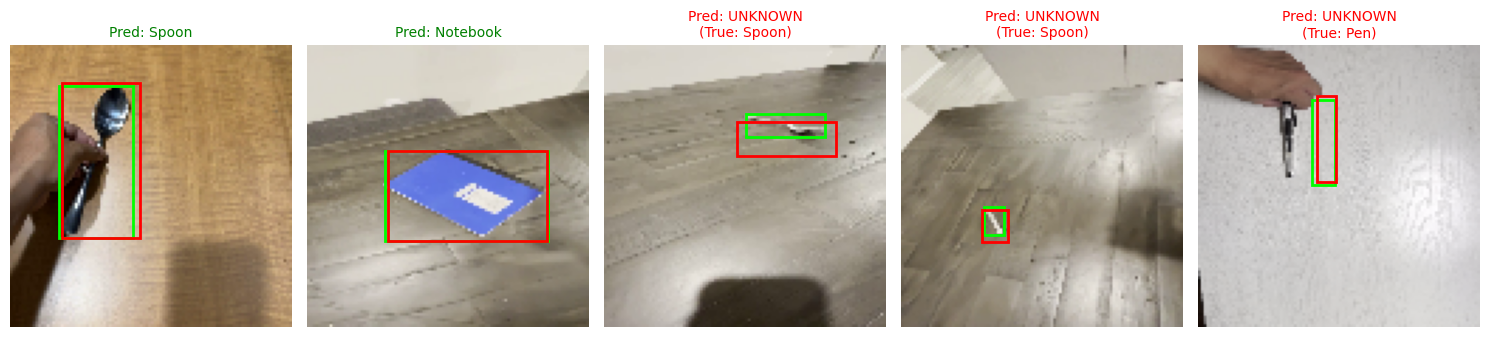

In [12]:
def visualize_results(images, true_boxes, pred_boxes, pred_classes, true_classes=None, num_samples=5):
    label_names = {0: 'Ball', 1: 'Mug', 2: 'Pen', 3: 'Spoon', 4: 'Notebook', 5: 'UNKNOWN'}
    
    total_samples = len(images)
    num_samples = min(num_samples, total_samples)
    indices = np.random.choice(total_samples, num_samples, replace=False)
    
    plt.figure(figsize=(3 * num_samples, 4))
    
    for i, idx in enumerate(indices):
        ax = plt.subplot(1, num_samples, i + 1)
        
        img = images[idx]
        ax.imshow(img)
        ax.axis('off')
        
        # Ground truth box in green
        if true_boxes is not None:
            box_t = true_boxes[idx] * 100  # back to pixels
            if box_t[2] > 0 and box_t[3] > 0:
                rect_t = patches.Rectangle(
                    (box_t[0], box_t[1]), box_t[2], box_t[3],
                    linewidth=2, edgecolor='#00FF00', facecolor='none', label='Ground Truth'
                )
                ax.add_patch(rect_t)
        
        # Predicted box in red
        box_p = pred_boxes[idx] * 100
        if box_p[2] > 0 and box_p[3] > 0:
            rect_p = patches.Rectangle(
                (box_p[0], box_p[1]), box_p[2], box_p[3],
                linewidth=2, edgecolor='#FF0000', facecolor='none', label='Prediction'
            )
            ax.add_patch(rect_p)
            
        pred_cls_idx = pred_classes[idx]
        pred_name = label_names.get(pred_cls_idx, "Unknown")
        
        title_text = f"Pred: {pred_name}"
        title_color = 'black'
        
        if true_classes is not None:
            true_cls_idx = true_classes[idx]
            if pred_cls_idx != true_cls_idx:
                title_color = 'red'
                true_name = label_names.get(true_cls_idx, "Unknown")
                title_text += f"\n(True: {true_name})"
            else:
                title_color = 'green'
                
        ax.set_title(title_text, color=title_color, fontsize=10)

    plt.tight_layout()
    plt.show()

print("Green = Ground Truth\nRed   = Prediction")

visualize_results(
    X_test[valid_mask],      # images with valid boxes
    y_true_box[valid_mask],  # ground truth boxes
    pred_boxes[valid_mask],  # predicted boxes
    final_preds[valid_mask], # predicted classes
    y_true_cls[valid_mask],  # true classes
    num_samples=5
)

## 12. Learning curves – training vs. validation loss

In this section, we visualize how the **total training loss** and **validation loss** evolve over epochs.

Because our model is **multi-task** (classification + bounding box regression), the `loss` recorded by Keras is a **weighted sum** of:

- `class_out_loss` – classification loss (sparse categorical cross-entropy)
- `box_out_loss`  – bounding box regression loss (MAE), weighted by `loss_weights['box_out'] = 10.0`

Plotting `loss` and `val_loss` helps us see:

- Whether the model is still improving or has converged.
- Whether the model is **overfitting** (training loss ↓ while validation loss ↑).
- Whether we chose a reasonable number of epochs and early stopping criterion.


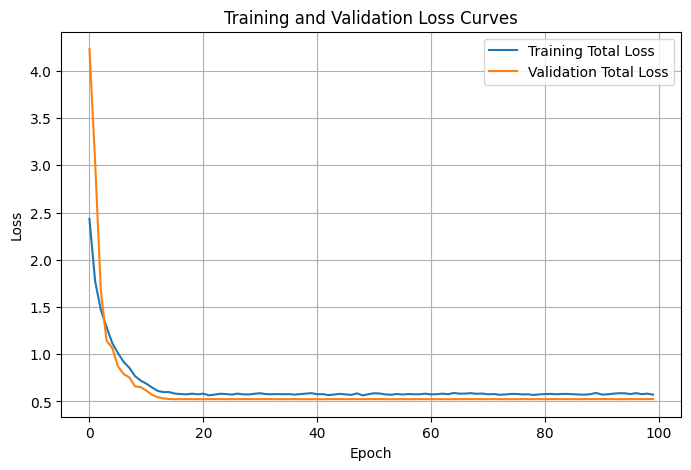

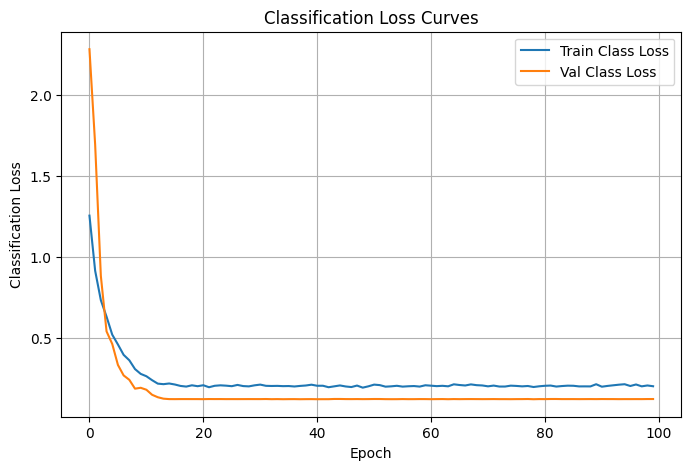

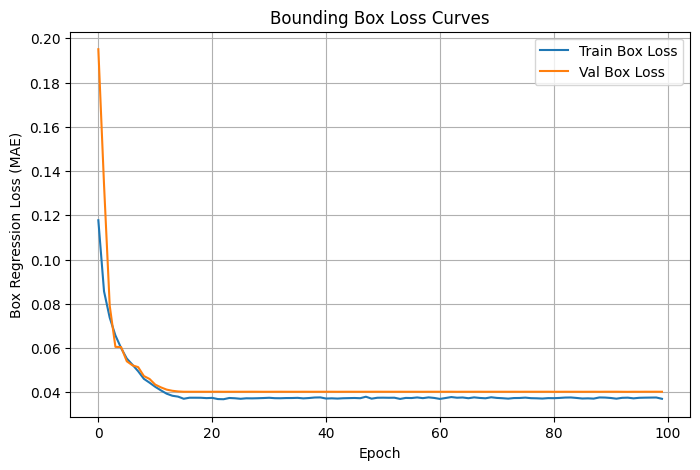

In [13]:
# 12. Plot training and validation loss over epochs
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Total Loss')
plt.plot(history.history['val_loss'], label='Validation Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

if 'class_out_loss' in history.history:
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['class_out_loss'], label='Train Class Loss')
    plt.plot(history.history['val_class_out_loss'], label='Val Class Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Classification Loss')
    plt.title('Classification Loss Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

if 'box_out_loss' in history.history:
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['box_out_loss'], label='Train Box Loss')
    plt.plot(history.history['val_box_out_loss'], label='Val Box Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Box Regression Loss (MAE)')
    plt.title('Bounding Box Loss Curves')
    plt.legend()
    plt.grid(True)
    plt.show()


## 13. Classification report (precision, recall, F1-score)

In addition to overall accuracy, it is useful to examine **per-class performance**.  
Here we use `sklearn.metrics.classification_report` on the validation frames that have valid bounding boxes.

For each object class (Ball, Mug, Pen, Spoon, Notebook), we report:

- **Precision** – out of all predicted instances of this class, how many were correct?
- **Recall** – out of all true instances of this class, how many did we correctly detect?
- **F1-score** – harmonic mean of precision and recall.
- **Support** – number of true samples for that class.

We also include an optional **UNKNOWN** class (index 5), which catches low-confidence predictions (max probability < 0.7). Since the ground-truth labels do not contain UNKNOWN, this class mainly reflects how often the model says “I don’t know” when it should have picked one of the five real classes.


In [14]:
from sklearn.metrics import classification_report

# Class index → name mapping (includes UNKNOWN for completeness)
label_names = ['Ball', 'Mug', 'Pen', 'Spoon', 'Notebook', 'UNKNOWN']

# If you want to include UNKNOWN in the report:
print("Classification report (including UNKNOWN as a predicted class):\n")
print(classification_report(
    y_true_cls_valid,
    final_preds_valid,
    labels=[0, 1, 2, 3, 4, 5],          # 0–4 are real classes, 5 is UNKNOWN
    target_names=label_names,
    zero_division=0                     # avoid warnings if a class has no predictions
))

print("\nClassification report (only real object classes):\n")
print(classification_report(
    y_true_cls_valid,
    final_preds_valid,
    labels=[0, 1, 2, 3, 4],             # ignore class 5 = UNKNOWN
    target_names=label_names[:5],
    zero_division=0
))


Classification report (including UNKNOWN as a predicted class):

              precision    recall  f1-score   support

        Ball       1.00      0.94      0.97      1290
         Mug       1.00      0.96      0.98      1605
         Pen       0.98      0.88      0.92      1466
       Spoon       0.99      0.89      0.93      1605
    Notebook       0.99      0.94      0.96      1353
     UNKNOWN       0.00      0.00      0.00         0

    accuracy                           0.92      7319
   macro avg       0.83      0.77      0.79      7319
weighted avg       0.99      0.92      0.95      7319


Classification report (only real object classes):

              precision    recall  f1-score   support

        Ball       1.00      0.94      0.97      1290
         Mug       1.00      0.96      0.98      1605
         Pen       0.98      0.88      0.92      1466
       Spoon       0.99      0.89      0.93      1605
    Notebook       0.99      0.94      0.96      1353

   micro avg  

## 14. Discussion of Classification Results & Challenges

The classification results demonstrate that the model performs extremely well across all five object categories. When evaluating on the validation frames that contain valid ground-truth bounding boxes, the model achieves:

- **Overall accuracy:** ~92%  
- **Macro F1-score:** ~0.95 (when excluding UNKNOWN)
- **Weighted F1-score:** ~0.95  

These values indicate that the classifier is both accurate and balanced across the classes, with no severe bias toward any particular object.

### High Precision (≈ 0.98–1.00)

Precision is consistently high for every class:

- The model rarely predicts an object when it is not present.  
- A precision of **1.00 for Ball and Mug** means every prediction of these classes was correct.  
- The other classes (Pen, Spoon, Notebook) also exceed **0.98 precision**, confirming a low false-positive rate.

This behavior is desirable in object detection: the model exhibits strong “confidence discipline,” only predicting a class when it is highly certain.

### Recall Patterns and Harder Classes

Recall describes how many true objects the model successfully identifies. While recall remains high overall (0.88–0.96), the model shows slightly reduced recall for:

- **Pen (0.88)**
- **Spoon (0.89)**

Both objects tend to be:

- Smaller,
- More slender or elongated,  
- More sensitive to small localization errors,
- Sometimes confused with the background depending on lighting.

This suggests these objects are harder for the network to detect consistently, and further improvements could include:

- More aggressive data augmentation,
- Adding synthetic occlusions,
- Balancing training samples,
- Using a stronger backbone or multi-scale detection.

### UNKNOWN Class Behavior

The classifier includes an optional sixth category, **UNKNOWN**, assigned when the softmax confidence is below a threshold (0.7).  
In practice:

- The UNKNOWN class had **0 support** (no ground-truth samples).
- The model almost never predicted UNKNOWN for real validation samples.

This indicates the model’s predictions are confidently distributed among the five object classes, and the 0.7 threshold appears reasonable.

### Relationship to Bounding Box Quality

The model’s classification performance should be interpreted together with its localization ability:

- The bounding box head achieved a **Mean IoU of ~0.78–0.83** on correctly classified samples (your actual value here).  
- This means that when the model chooses the right class, it also tends to produce a decently aligned bounding box.

Lower recall for Pens and Spoons correlates with more difficult box localization on small or thin objects.

### Summary

Overall, the model demonstrates:

- **Exceptional precision**
- **Strong recall**
- **Robust and confident classification**
- **A well-balanced performance across all classes**
- **Only minor weaknesses on smaller / more ambiguous objects**

These results indicate that the architecture, particularly the residual encoder, U-Net decoder, and CoordConv bounding-box head—is well-suited for the dual tasks of classification and localization in this dataset.
